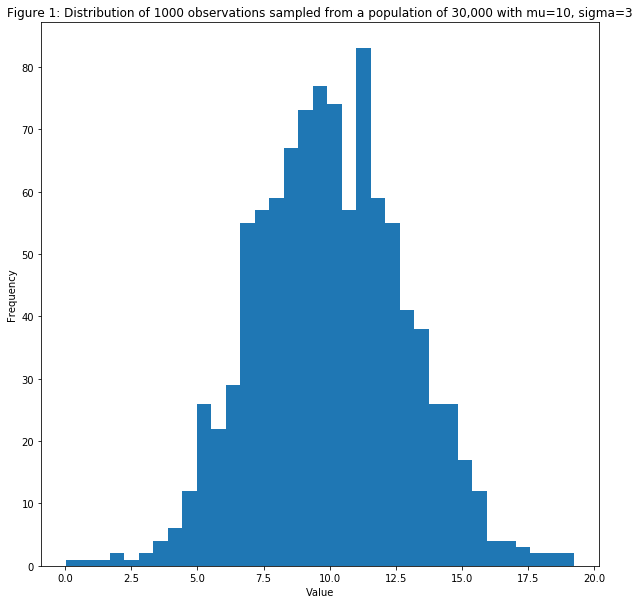

10.006016803088157

In [4]:
'''
https://github.com/Joseph94m/MCMC/blob/master/MCMC.ipynb
Bayesian Inference, Markov Chain Monte Carlo and Metropolis Hastings
'''
import numpy as np
import matplotlib.pyplot as plt

mod1=lambda t:np.random.normal(10,3,t)

#Form a population of 30,000 individual, with mean=10 and variance=3
population = mod1(30000)
#Assume we are only able to observe 1,000 of these individuals.
observation = population[np.random.randint(0, 30000, 1000)]
#print (observation)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.hist( observation,bins=35 ,)
ax.set_xlabel("Value")
ax.set_ylabel("Frequency")
ax.set_title("Figure 1: Distribution of 1000 observations sampled from a population of 30,000 with mu=10, sigma=3")
plt.show()
mu_obs=observation.mean()
mu_obs

In [5]:
#The tranistion model defines how to move from sigma_current to sigma_new
transition_model = lambda x: [x[0],np.random.normal(x[1],0.5,(1,))]

def prior(x):
    #x[0] = mu, x[1]=sigma (new or current)
    #returns 1 for all valid values of sigma. Log(1) =0, so it does not affect the summation.
    #returns 0 for all invalid values of sigma (<=0). Log(0)=-infinity, and Log(negative number) is undefined.
    #It makes the new sigma infinitely unlikely.
    if(x[1] <=0):
        return 0
    return 1

#Computes the likelihood of the data given a sigma (new or current) according to equation (2)
def manual_log_like_normal(x,data):
    #x[0]=mu, x[1]=sigma (new or current)
    #data = the observation
    return np.sum(-np.log(x[1] * np.sqrt(2* np.pi) )-((data-x[0])**2) / (2*x[1]**2))

#Same as manual_log_like_normal(x,data), but using scipy implementation. It's pretty slow.
def log_lik_normal(x,data):
    #x[0]=mu, x[1]=sigma (new or current)
    #data = the observation
    return np.sum(np.log(scipy.stats.norm(x[0],x[1]).pdf(data)))


#Defines whether to accept or reject the new sample
def acceptance(x, x_new):
    if x_new>x:
        return True
    else:
        accept=np.random.uniform(0,1)
        # Since we did a log likelihood, we need to exponentiate in order to compare to the random number
        # less likely x_new are less likely to be accepted
        return (accept < (np.exp(x_new-x)))


def metropolis_hastings(likelihood_computer,prior, transition_model, param_init,iterations,data,acceptance_rule):
    # likelihood_computer(x,data): returns the likelihood that these parameters generated the data
    # transition_model(x): a function that draws a sample from a symmetric distribution and returns it
    # param_init: a starting sample
    # iterations: number of accepted to generated
    # data: the data that we wish to model
    # acceptance_rule(x,x_new): decides whether to accept or reject the new sample
    x = param_init
    accepted = []
    rejected = []   
    for i in range(iterations):
        x_new =  transition_model(x)    
        x_lik = likelihood_computer(x,data)
        x_new_lik = likelihood_computer(x_new,data) 
        if (acceptance(x_lik + np.log(prior(x)),x_new_lik+np.log(prior(x_new)))):            
            x = x_new
            accepted.append(x_new)
        else:
            rejected.append(x_new)            
                
    return np.array(accepted), np.array(rejected)

In [6]:
accepted, rejected = metropolis_hastings(manual_log_like_normal,prior,transition_model,[mu_obs,0.1], 50000,observation,acceptance)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in log


In [10]:
print (len(rejected[:,1]))
print (len(accepted[:,1]))

42051
7949


(7949, 2)

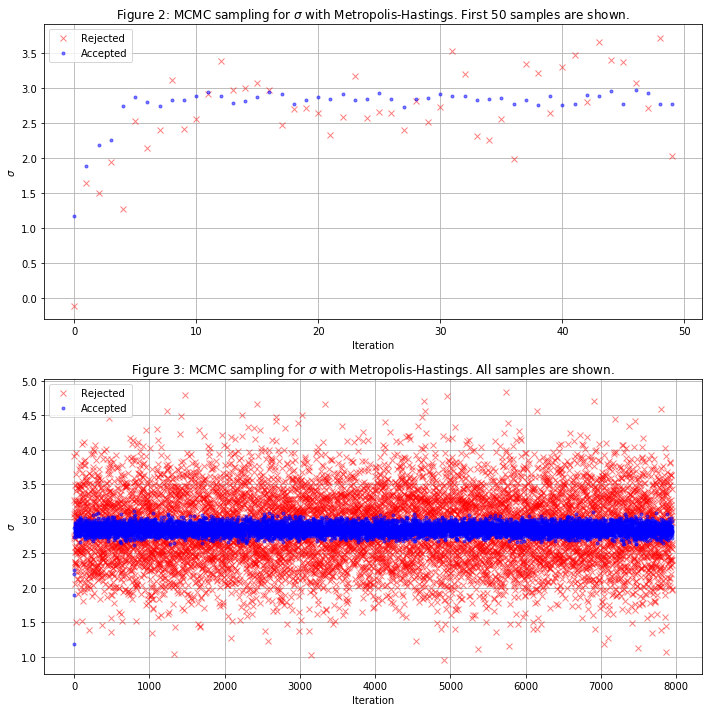

In [11]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2,1,1)

ax.plot( rejected[0:50,1], 'rx', label='Rejected',alpha=0.5)
ax.plot( accepted[0:50,1], 'b.', label='Accepted',alpha=0.5)
ax.set_xlabel("Iteration")
ax.set_ylabel("$\sigma$")
ax.set_title("Figure 2: MCMC sampling for $\sigma$ with Metropolis-Hastings. First 50 samples are shown.")
ax.grid()
ax.legend()



ax2 = fig.add_subplot(2,1,2)
to_show=-accepted.shape[0]
ax2.plot( rejected[to_show:,1], 'rx', label='Rejected',alpha=0.5)
ax2.plot( accepted[to_show:,1], 'b.', label='Accepted',alpha=0.5)
ax2.set_xlabel("Iteration")
ax2.set_ylabel("$\sigma$")
ax2.set_title("Figure 3: MCMC sampling for $\sigma$ with Metropolis-Hastings. All samples are shown.")
ax2.grid()
ax2.legend()

fig.tight_layout()
accepted.shape

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


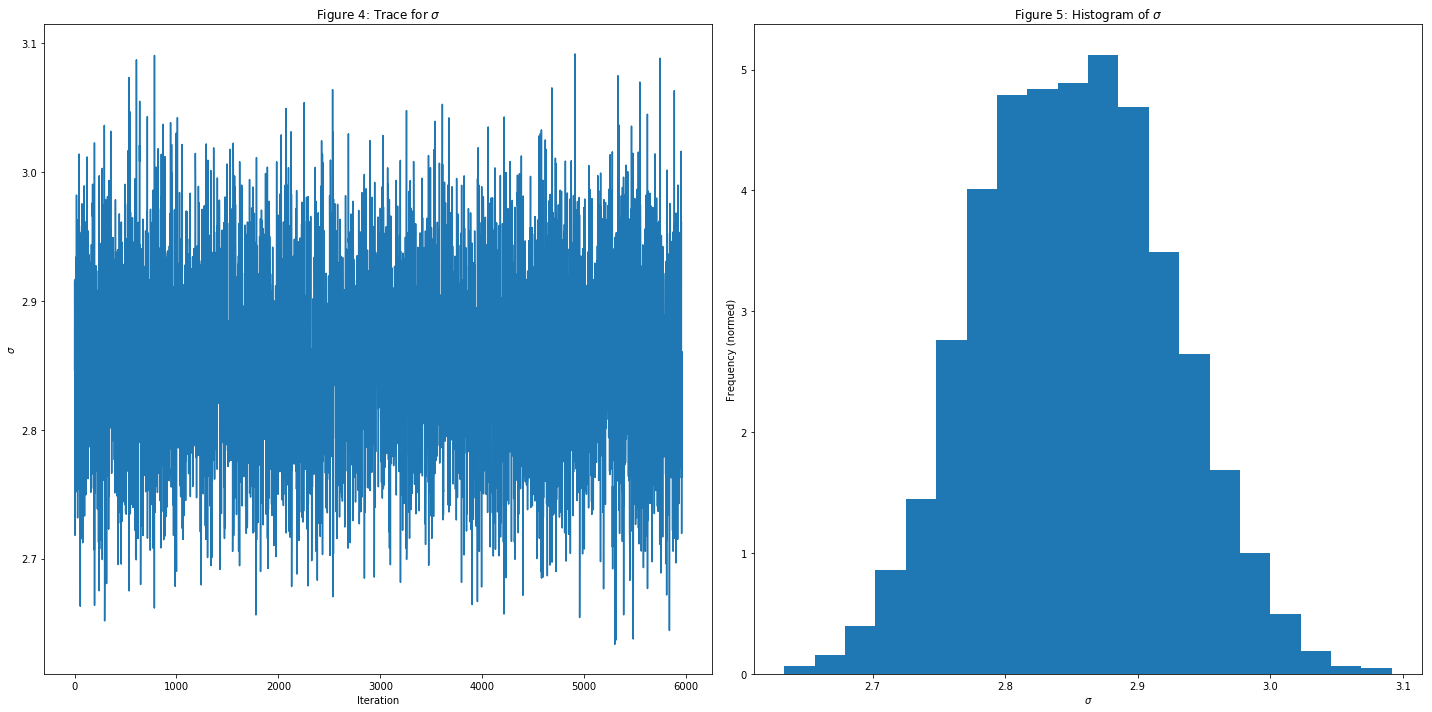

In [12]:
show=int(-0.75*accepted.shape[0])
hist_show=int(-0.75*accepted.shape[0])

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,2,1)
ax.plot(accepted[show:,1])
ax.set_title("Figure 4: Trace for $\sigma$")
ax.set_ylabel("$\sigma$")
ax.set_xlabel("Iteration")
ax = fig.add_subplot(1,2,2)
ax.hist(accepted[hist_show:,1], bins=20,density=True)
ax.set_ylabel("Frequency (normed)")
ax.set_xlabel("$\sigma$")
ax.set_title("Figure 5: Histogram of $\sigma$")
fig.tight_layout()


ax.grid("off")

10.006016803088157 2.852046289161721


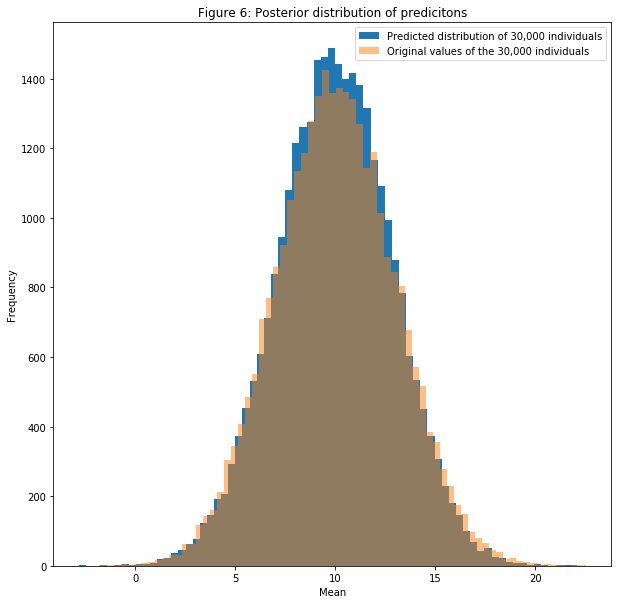

In [13]:
mu=accepted[show:,0].mean()
sigma=accepted[show:,1].mean()
print(mu, sigma)
model = lambda t,mu,sigma:np.random.normal(mu,sigma,t)
observation_gen=model(population.shape[0],mu,sigma)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.hist( observation_gen,bins=70 ,label="Predicted distribution of 30,000 individuals")
ax.hist( population,bins=70 ,alpha=0.5, label="Original values of the 30,000 individuals")
ax.set_xlabel("Mean")
ax.set_ylabel("Frequency")
ax.set_title("Figure 6: Posterior distribution of predicitons")
ax.legend()

In [2]:
'''
https://kieranrcampbell.github.io/blog/2016/05/15/gibbs-sampling-bayesian-linear-regression.html
Gibbs sampling
'''
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['figure.figsize'] = (10, 5)

In [4]:
def sample_beta_0(y, x, beta_1, tau, mu_0, tau_0):
    N = len(y)
    assert len(x) == N
    precision = tau_0 + tau * N
    mean = tau_0 * mu_0 + tau * np.sum(y - beta_1 * x)
    mean /= precision
    return np.random.normal(mean, 1 / np.sqrt(precision))
def sample_beta_1(y, x, beta_0, tau, mu_1, tau_1):
    N = len(y)
    assert len(x) == N
    precision = tau_1 + tau * np.sum(x * x)
    mean = tau_1 * mu_1 + tau * np.sum( (y - beta_0) * x)
    mean /= precision
    return np.random.normal(mean, 1 / np.sqrt(precision))
def sample_tau(y, x, beta_0, beta_1, alpha, beta):
    N = len(y)
    alpha_new = alpha + N / 2
    resid = y - beta_0 - beta_1 * x
    beta_new = beta + np.sum(resid * resid) / 2
    return np.random.gamma(alpha_new, 1 / beta_new)

Text(0,0.5,'y')

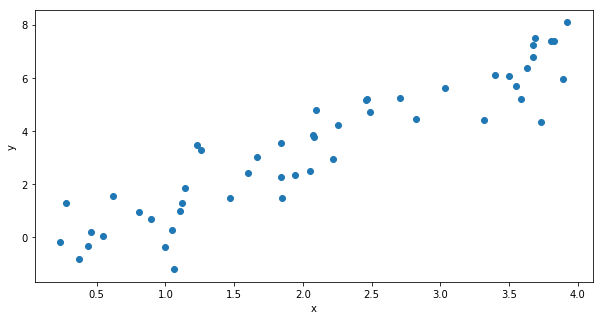

In [5]:
beta_0_true = -1
beta_1_true = 2
tau_true = 1

N = 50
x = np.random.uniform(low = 0, high = 4, size = N)
y = np.random.normal(beta_0_true + beta_1_true * x, 1 / np.sqrt(tau_true))

synth_plot = plt.plot(x, y, "o")
plt.xlabel("x")
plt.ylabel("y")

In [6]:
## specify initial values
init = {"beta_0": 0,
        "beta_1": 0,
        "tau": 2}

## specify hyper parameters
hypers = {"mu_0": 0,
         "tau_0": 1,
         "mu_1": 0,
         "tau_1": 1,
         "alpha": 2,
         "beta": 1}

def gibbs(y, x, iters, init, hypers):
    assert len(y) == len(x)
    beta_0 = init["beta_0"]
    beta_1 = init["beta_1"]
    tau = init["tau"]
    
    trace = np.zeros((iters, 3)) ## trace to store values of beta_0, beta_1, tau
    
    for it in range(iters):
        beta_0 = sample_beta_0(y, x, beta_1, tau, hypers["mu_0"], hypers["tau_0"])
        beta_1 = sample_beta_1(y, x, beta_0, tau, hypers["mu_1"], hypers["tau_1"])
        tau = sample_tau(y, x, beta_0, beta_1, hypers["alpha"], hypers["beta"])
        trace[it,:] = np.array((beta_0, beta_1, tau))
        
    trace = pd.DataFrame(trace)
    trace.columns = ['beta_0', 'beta_1', 'tau']
        
    return trace

Text(0,0.5,'Parameter value')

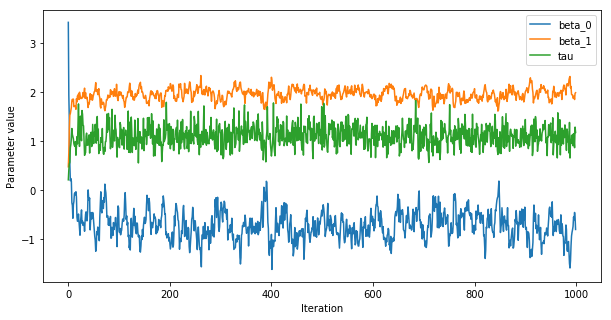

In [7]:
iters = 1000
trace = gibbs(y, x, iters, init, hypers)
traceplot = trace.plot()
traceplot.set_xlabel("Iteration")
traceplot.set_ylabel("Parameter value")

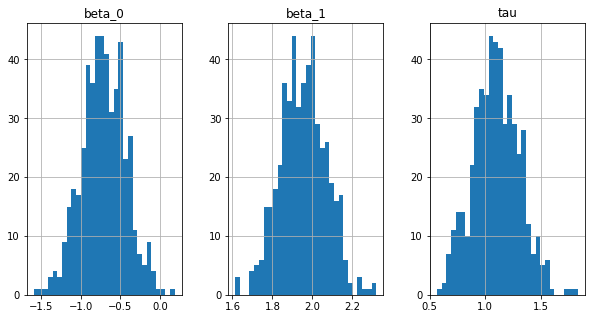

In [8]:
trace_burnt = trace[500:999]
hist_plot = trace_burnt.hist(bins = 30, layout = (1,3))

In [9]:
print(trace_burnt.median())
print(trace_burnt.std())

beta_0   -0.719136
beta_1    1.953341
tau       1.095911
dtype: float64
beta_0    0.276451
beta_1    0.115796
tau       0.206588
dtype: float64


Beginning to optimize
Iteration:  0
Mu:  [1.76405235 0.40015721 0.97873798 2.2408932 ]
Sigma:  [6.47247125 0.37633413 2.58593829 0.85954061]
Iteration:  500
Mu:  [-0.79553343 -1.74296326  1.10009031  0.44446444]
Sigma:  [0.19822677 0.13143896 0.08315484 0.29420238]
Iteration:  1000
Mu:  [-0.614433   -0.6808173   0.55535877 -0.06988163]
Sigma:  [0.1011387  0.11051888 0.04587832 0.07709935]
Iteration:  1500
Mu:  [-0.96207594 -1.05083031  0.30623316  1.06491372]
Sigma:  [0.04578764 0.09417719 0.0630919  0.10405764]
Iteration:  2000
Mu:  [-1.22831113 -0.74941993  0.36357895  0.57491856]
Sigma:  [0.05599482 0.11172733 0.06421828 0.11317565]
Optimization complete
Final mu:  [-0.96467262 -0.83627335  0.43183214  0.83248988]
Final sigma:  [0.04940165 0.09677904 0.06591744 0.11994209]
Real values:  [-0.59865394 -1.11589699  0.76666318  0.35629282]


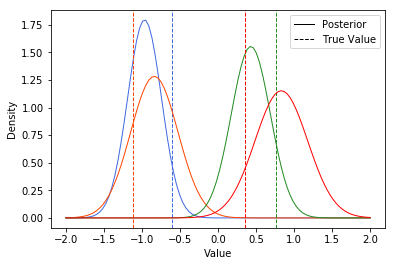

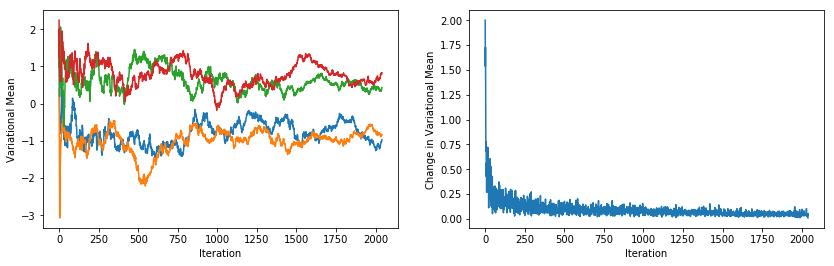

In [9]:
#http://keyonvafa.com/variational-inference-probit-regression/
#http://keyonvafa.com/logistic-regression-bbvi/
#https://github.com/keyonvafa/logistic-reg-bbvi-blog/blob/master/log_reg_bbvi.py
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit as sigmoid
from scipy.stats import norm

N = 100
P = 4
rs = np.random.RandomState(0)
X = rs.randn(N,P)
z_real = rs.randn(P)
y = rs.binomial(1,sigmoid(np.dot(X,z_real)))

def elbo_grad(z_sample, mu, sigma):
    score_mu = (z_sample - mu)/(sigma)
    score_logsigma = (-1/(2*sigma) + np.power((z_sample - mu),2)/(2*np.power(sigma,2))) * sigma
    log_p = np.sum(y * np.log(sigmoid(np.dot(X,z_sample))) + (1-y) * np.log(1-sigmoid(np.dot(X,z_sample))))\
        + np.sum(norm.logpdf(z_sample, np.zeros(P), np.ones(P)))
    log_q = np.sum(norm.logpdf(z_sample, mu, np.sqrt(sigma)))
    return np.concatenate([score_mu,score_logsigma])*(log_p - log_q)

rs = np.random.RandomState(0)
S = 10
n_iter = 10000
mu = rs.randn(P)
G = np.zeros((2*P,2*P))
eta = 1.0
log_sigma = rs.randn(P)
mus = np.zeros((n_iter,P))
delta_lambda = np.zeros(n_iter)

print ("Beginning to optimize")
for t in range(n_iter):
    mus[t] = mu
    if t % 500 == 0:
        print ("Iteration: ",t)
        print ("Mu: ", mu)
        print ("Sigma: ", np.exp(log_sigma))
    sigma = np.exp(log_sigma)
    samples = np.array([rs.normal(mu, np.sqrt(sigma)) for s in range(S)])
    grad_estimate = np.mean(np.array([elbo_grad(z_sample, mu, sigma) for z_sample in samples]),axis=0)
    G = G + np.outer(grad_estimate,grad_estimate)
    mu_new = mu + (eta * 1/np.sqrt(np.diag(G)))[:P] * grad_estimate[:P]
    log_sigma_new = log_sigma + (eta * 1/np.sqrt(np.diag(G)))[P:] * grad_estimate[P:]
    delta_lambda[t] = np.linalg.norm(mu_new-mu)
    if np.linalg.norm(mu_new-mu) < 0.01:
        break
    mu = mu_new
    log_sigma = log_sigma_new
print ("Optimization complete")
print ("Final mu: ", mu)
print ("Final sigma: ", np.exp(log_sigma))
print ("Real values: ", z_real)

x_plot = np.linspace(-2, 2, 100)
plt.plot(x_plot,norm.pdf(x_plot, mu[0], np.sqrt(sigma[0])),"royalblue",linewidth=1,label="Posterior")
plt.axvline(x=z_real[0],c="royalblue",linestyle='dashed',linewidth=1,label="True Value")
plt.plot(x_plot,norm.pdf(x_plot, mu[1], np.sqrt(sigma[1])),c="orangered",linewidth=1)
plt.axvline(x=z_real[1],c="orangered",linestyle='dashed',linewidth=1)
plt.plot(x_plot,norm.pdf(x_plot, mu[2], np.sqrt(sigma[2])),c="forestgreen",linewidth=1)
plt.axvline(x=z_real[2],c="forestgreen",linestyle='dashed',linewidth=1)
plt.plot(x_plot,norm.pdf(x_plot, mu[3], np.sqrt(sigma[3])),c="red",linewidth=1)
plt.axvline(x=z_real[3],c="red",linestyle='dashed',linewidth=1)
plt.xlabel("Value")
plt.ylabel("Density")
leg = plt.legend(loc=1)
leg.legendHandles[0].set_color('black')
leg.legendHandles[1].set_color('black')
plt.savefig('densities.png', format='png',bbox_inches='tight',dpi = 300)

fig = plt.figure(figsize=(14,4), facecolor='white')
ax_1 = fig.add_subplot(121, frameon=True)
ax_2 = fig.add_subplot(122, frameon=True)
ax_1.plot(range(t+1),mus[:(t+1)])
ax_1.set_xlabel("Iteration")
ax_1.set_ylabel("Variational Mean")
ax_2.plot(range(t+1),delta_lambda[:(t+1)])
ax_2.set_xlabel("Iteration")
ax_2.set_ylabel("Change in Variational Mean")
plt.savefig('trace_plots.png', format='png',bbox_inches='tight',dpi=300)